In [1]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,porter
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import ExtraTreesClassifier as etc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn import metrics

import string
import pandas as pd
import numpy as np
import re
import pickle
import gc

from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,10]

# Define pre-processing functions for text

In [2]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(",".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def top_words(model,feature_names,n_top_words):
    topics = []
    terms = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append(topic_idx)
        terms.append(','.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return pandas.DataFrame({'topic':topics,'terms':terms},columns=['topic','terms'])    

def noPunct(txt):
    punct_list = string.punctuation + '’' + '”' + '“'
    for punct in punct_list:
        if txt.startswith('not_'):
            txt = txt[:4] + txt[4:].replace(punct,'')
        else:
            txt = txt.replace(punct,'')
    return txt

def noNumber(txt):
    return re.sub(r'[$\s]*\d+\.?\d*','',txt)

def addNegation(x):
    pattern = r'not? +(\w+)'
    repl = r'not_\1'
    q = re.sub(pattern,repl,x,flags=re.IGNORECASE)
    
    pattern = r'n\'t +(\w+)'
    repl = r' not_\1'
    q = re.sub(pattern,repl,q,flags=re.IGNORECASE)
    
    return q

def LemmaTokenizer(doc):
    doc = addNegation(doc)
    wnl = WordNetLemmatizer()
    lemmas =[wnl.lemmatize(t) for t in word_tokenize(doc)]
    lemmas = [noPunct(l) for l in lemmas]
#     lemmas = [noNumber(l) for l in lemmas]
    lemmas = list(filter(lambda x: len(x) > 0,lemmas))
    return lemmas

def StemmerTokenizer(doc):
    doc = addNegation(doc)
    port = porter.PorterStemmer()
    tokens = [port.stem(t) for t in word_tokenize(doc)]
    tokens = [noPunct(t) for t in tokens]
#     tokens = [noNumber(l) for l in tokens]
    tokens = list(filter(lambda x: len(x) > 0,tokens))
    return tokens

# extra_stopwords = stopwords.words('english') + ['company','would','get','school','student','sally','salliemae','im','sallie','mae','loan','nt','wo','wa','tg','va','ca','mo','le','ha','sm','itt','k','smae']
# extra_stopwords = extra_stopwords + ['not_' + x for x in extra_stopwords]

In [3]:
train = pd.read_csv("train.csv",header=None,names=["score","review"],dtype={"score":np.int,"review":np.str})
test = pd.read_csv("test.csv",header=None,names=["score","review"],dtype={"score":np.int,"review":np.str})
display(train.head())
display(test.head())

,score,review
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


,score,review
0,1,I got 'new' tires from them and within two wee...
1,1,Don't waste your time. We had two different p...
2,1,All I can say is the worst! We were the only 2...
3,1,I have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...


In [38]:
tfidf_maker = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=stopwords.words('english'),tokenizer=LemmaTokenizer,
                        ngram_range=(1,2), binary=False, norm='l1', use_idf=True, smooth_idf=True, sublinear_tf=True,
                       max_features=None,min_df=1000,max_df=0.9)
tfidf = tfidf_maker.fit_transform(train['review'])
tfidf_test = tfidf_maker.transform(test['review'])
with open('tfidf_maker','wb') as wr:
    pickle.dump(tfidf_maker,wr)
with open('tfidf','wb') as wr:
    pickle.dump(tfidf,wr)
with open('tfidf_test','wb') as wr:    
    pickle.dump(tfidf_test,wr)

In [4]:
with open("tfidf_maker","rb") as rd:
    tfidf_maker = pickle.load(rd)
with open("tfidf","rb") as rd:
    tfidf = pickle.load(rd)
with open("tfidf_test","rb") as rd:
    tfidf_test = pickle.load(rd)

In [21]:
feature_names = tfidf_maker.get_feature_names()
for i,j in enumerate(feature_names):
    print(i,j)

0 0
1 0 star
2 1
3 1 hour
4 1 star
5 10
6 10 min
7 10 minute
8 10 year
9 100
10 1000
11 1015
12 10pm
13 11
14 110
15 11am
16 11pm
17 12
18 12 hour
19 13
20 14
21 15
22 15 min
23 15 minute
24 150
25 1520
26 16
27 17
28 18
29 19
30 1st
31 2
32 2 3
33 2 day
34 2 hour
35 2 minute
36 2 people
37 2 star
38 2 time
39 2 week
40 2 year
41 20
42 20 min
43 20 minute
44 20 year
45 200
46 2000
47 2011
48 2012
49 2013
50 2014
51 21
52 22
53 23
54 24
55 24 hour
56 247
57 25
58 25 minute
59 250
60 26
61 28
62 2nd
63 3
64 3 4
65 3 day
66 3 different
67 3 hour
68 3 people
69 3 star
70 3 time
71 3 year
72 30
73 30 min
74 30 minute
75 300
76 32
77 34
78 35
79 35 star
80 350
81 3pm
82 3rd
83 4
84 4 5
85 4 hour
86 4 people
87 4 star
88 4 time
89 4 year
90 40
91 40 minute
92 400
93 45
94 45 min
95 45 minute
96 45 star
97 4pm
98 4th
99 5
100 5 min
101 5 minute
102 5 star
103 5 time
104 5 year
105 50
106 500
107 55
108 5pm
109 5th
110 6
111 6 month
112 60
113 600
114 65
115 6pm
116 7
117 70
118 700
119 730
120

1411 dip wa
1412 dipped
1413 dipping
1414 dipping sauce
1415 direct
1416 directed
1417 direction
1418 directly
1419 dirt
1420 dirty
1421 disappeared
1422 disappointed
1423 disappointed wa
1424 disappointing
1425 disappointment
1426 disaster
1427 discount
1428 discounted
1429 discover
1430 discovered
1431 disgusted
1432 disgusting
1433 dish
1434 dish wa
1435 dislike
1436 disorganized
1437 display
1438 distance
1439 district
1440 dive
1441 dive bar
1442 diverse
1443 divine
1444 dj
1445 doctor
1446 doe
1447 doe not_even
1448 doe not_get
1449 doe not_have
1450 doe not_make
1451 doe not_matter
1452 doe not_mean
1453 doe not_seem
1454 doesnt
1455 dog
1456 dog wa
1457 dollar
1458 done
1459 done wa
1460 dont
1461 dont know
1462 donut
1463 door
1464 door wa
1465 double
1466 doubt
1467 dough
1468 downhill
1469 downright
1470 downside
1471 downstairs
1472 downtown
1473 dozen
1474 dr
1475 draft
1476 drank
1477 draw
1478 dream
1479 drenched
1480 dress
1481 dressed
1482 dressing
1483 dressing wa
148

2509 hour
2510 hour get
2511 hour half
2512 hour later
2513 hour menu
2514 hour wa
2515 hour wait
2516 house
2517 house wa
2518 housekeeping
2519 however
2520 however wa
2521 hr
2522 http
2523 hub
2524 hubby
2525 huge
2526 huge fan
2527 huge portion
2528 huh
2529 human
2530 hummus
2531 hundred
2532 hung
2533 hungry
2534 hunt
2535 hurry
2536 hurt
2537 husband
2538 husband got
2539 husband ordered
2540 husband wa
2541 husband went
2542 hut
2543 hype
2544 ice
2545 ice cream
2546 ice tea
2547 iceberg
2548 iced
2549 iced tea
2550 icing
2551 id
2552 idea
2553 ideal
2554 idiot
2555 ie
2556 ignore
2557 ignored
2558 ihop
2559 il
2560 ill
2561 im
2562 imagine
2563 immediately
2564 imo
2565 impeccable
2566 important
2567 importantly
2568 impossible
2569 impress
2570 impressed
2571 impression
2572 impressive
2573 improve
2574 improved
2575 improvement
2576 inch
2577 incident
2578 include
2579 included
2580 includes
2581 including
2582 incompetent
2583 inconsistent
2584 inconvenience
2585 incorrect

3578 not_make
3579 not_many
3580 not_matter
3581 not_mean
3582 not_mind
3583 not_miss
3584 not_more
3585 not_much
3586 not_my
3587 not_my favorite
3588 not_nearly
3589 not_necessarily
3590 not_need
3591 not_notice
3592 not_offer
3593 not_on
3594 not_once
3595 not_one
3596 not_one wa
3597 not_only
3598 not_only wa
3599 not_open
3600 not_order
3601 not_other
3602 not_over
3603 not_overly
3604 not_particularly
3605 not_pay
3606 not_plan
3607 not_problem
3608 not_put
3609 not_quite
3610 not_ready
3611 not_real
3612 not_realize
3613 not_really
3614 not_reason
3615 not_recommend
3616 not_recommend place
3617 not_remember
3618 not_return
3619 not_say
3620 not_see
3621 not_seem
3622 not_seen
3623 not_serve
3624 not_show
3625 not_so
3626 not_so good
3627 not_so great
3628 not_so much
3629 not_something
3630 not_speak
3631 not_stand
3632 not_stay
3633 not_stop
3634 not_super
3635 not_sure
3636 not_sure wa
3637 not_take
3638 not_taste
3639 not_taste like
3640 not_tell
3641 not_terrible
3642 not_t

4568 safety
4569 said
4570 said could
4571 said oh
4572 said wa
4573 said would
4574 said yes
4575 sake
4576 salad
4577 salad bar
4578 salad sandwich
4579 salad wa
4580 sale
4581 salmon
4582 salmon wa
4583 salon
4584 salsa
4585 salsa wa
4586 salt
4587 salt pepper
4588 salted
4589 salty
4590 sam
4591 sample
4592 sampled
4593 sampler
4594 san
4595 san diego
4596 san francisco
4597 sand
4598 sandwich
4599 sandwich wa
4600 sangria
4601 sans
4602 sashimi
4603 sat
4604 sat bar
4605 sat outside
4606 sat table
4607 sat u
4608 satisfied
4609 satisfy
4610 satisfying
4611 saturday
4612 saturday afternoon
4613 saturday morning
4614 saturday night
4615 sauce
4616 sauce wa
4617 sausage
4618 sausage wa
4619 sauteed
4620 save
4621 save money
4622 saved
4623 saving
4624 saving grace
4625 savory
4626 saw
4627 saw wa
4628 say
4629 say food
4630 say least
4631 say place
4632 say wa
4633 saying
4634 scale
4635 scallop
4636 scam
4637 scared
4638 scary
4639 scene
4640 schedule
4641 scheduled
4642 school
4643

5586 unlike
5587 unlimited
5588 unnecessary
5589 unpleasant
5590 unprofessional
5591 unusual
5592 update
5593 updated
5594 upgrade
5595 upgraded
5596 upon
5597 upon arrival
5598 upper
5599 ups
5600 upscale
5601 upset
5602 upside
5603 upstairs
5604 uptown
5605 urban
5606 us
5607 use
5608 used
5609 used go
5610 used love
5611 using
5612 usual
5613 usually
5614 usually get
5615 usually go
5616 utensil
5617 v
5618 vacation
5619 valet
5620 valley
5621 value
5622 vanilla
5623 varied
5624 variety
5625 various
5626 vast
5627 veal
5628 vega
5629 vega strip
5630 vega trip
5631 vega wa
5632 vegan
5633 vegetable
5634 vegetarian
5635 vegetarian option
5636 veggie
5637 vehicle
5638 velvet
5639 vendor
5640 venetian
5641 venture
5642 venue
5643 version
5644 vet
5645 via
5646 vibe
5647 video
5648 vietnamese
5649 view
5650 view strip
5651 view wa
5652 village
5653 vinaigrette
5654 vinegar
5655 vintage
5656 vip
5657 visit
5658 visit wa
5659 visited
5660 visiting
5661 visitor
5662 vodka
5663 voice
5664 vo

In [17]:
gbm_model = gbc(learning_rate=0.1,n_estimators = 1000,max_depth=6,max_features='sqrt',verbose=2)
et_model = etc(n_estimators=100,criterion='gini',max_features='auto',max_depth=50,n_jobs=8,verbose=2,warm_start=True)

In [33]:
with open("gbm_model","rb") as rd:
    gbm_model = pickle.load(rd)
with open("et_model","rb") as rd:
    et_model = pickle.load(rd)    

In [18]:
et_model.fit(X=tfidf,y=train['score'].values)
with open('et_model','wb') as wr:
    pickle.dump(et_model,wr)

building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100building tree 8 of 100







building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.0min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 11.0min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=50, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=8, oob_score=False, random_state=None,
           verbose=2, warm_start=True)

,importance
great,0.007334
highly recommend,0.007201
2 star,0.007178
love,0.006263
worst,0.005883
best,0.005448
3 star,0.005328
rude,0.005251
asked,0.004779
told,0.004768


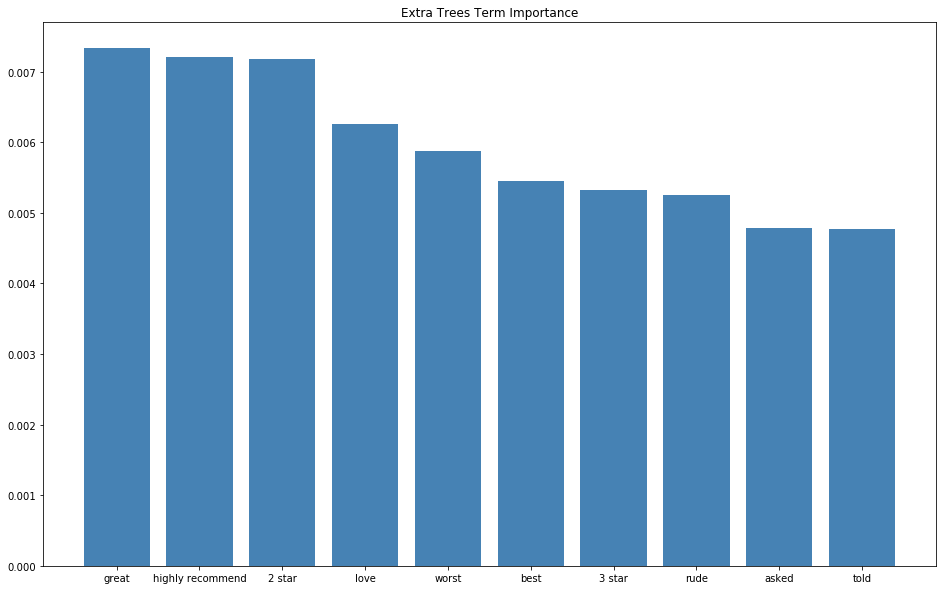

In [39]:
fi = pd.DataFrame({'importance':et_model.feature_importances_},index=feature_names).sort_values('importance',ascending=False)
display(fi.iloc[:10])

ticks = np.arange(10)
plt.bar(ticks,fi['importance'][:10],color='steelblue')
plt.xticks(ticks,fi.index)
plt.title('Extra Trees Term Importance')
plt.show()

In [12]:
p = et_model.predict(tfidf_test)
cm = metrics.confusion_matrix(test['score'],p)
display(cm)
for i in range(5):
    print(i+1,cm[i,i]/np.sum(cm[i,:]))
print()
print(metrics.accuracy_score(test['score'],p))

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


array([[7387, 1478,  328,  190,  617],
       [2869, 3834, 1893,  614,  790],
       [ 945, 1743, 4017, 2029, 1266],
       [ 417,  517, 1675, 3766, 3625],
       [ 467,  192,  480, 1922, 6939]])

1 0.7387
2 0.3834
3 0.4017
4 0.3766
5 0.6939

0.51886


In [10]:
class myMonitor:
    def __call__(self,i,locals,x):
        yp = np.argmax(x['y_pred'],1) + 1
        res = metrics.accuracy_score(x['y'],yp)
        perf_train.append(res)
        return False

In [13]:
perf_train = []
gbm_model.fit(X=tfidf,y=train['score'].values,monitor=myMonitor())
with open("gbm_model","wb") as wr:
    pickle.dump(gbm_model,wr)
with open("gbm_perf_train","wb") as wr:
    pickle.dump(perf_train,wr)

      Iter       Train Loss   Remaining Time 
         1     1036316.5468          104.72m
         2     1026784.0209           99.94m
         3     1019602.0566           97.07m
         4     1010881.0519           95.48m
         5     1003597.2190           94.44m
         6      996226.6601           94.20m
         7      986987.1139           94.93m
         8      981016.2807           93.80m
         9      974508.6604           93.09m
        10      967708.6947           93.02m
        11      963081.0847           92.29m
        12      957729.0510           91.59m
        13      952574.2245           91.29m
        14      946720.2826           91.05m
        15      942099.1128           90.95m
        16      936952.7447           90.83m
        17      931059.1467           90.66m
        18      926512.1245           90.44m
        19      921771.2038           90.37m
        20      917522.2447           90.15m
        21      913214.0029           90.00m
        2

       183      685178.0276           73.88m
       184      684705.2697           73.81m
       185      684203.7221           73.71m
       186      683780.6362           73.62m
       187      683353.6535           73.52m
       188      682779.8609           73.43m
       189      682317.3271           73.34m
       190      681845.2960           73.25m
       191      681348.6174           73.16m
       192      680901.1062           73.08m
       193      680422.9144           73.01m
       194      679953.7751           72.90m
       195      679512.4848           72.79m
       196      679109.3804           72.72m
       197      678617.2015           72.61m
       198      678100.4231           72.53m
       199      677623.9563           72.45m
       200      677180.5968           72.35m
       201      676718.5587           72.28m
       202      676177.0815           72.22m
       203      675681.7731           72.14m
       204      675172.7066           72.08m
       205

       366      624874.0723           56.78m
       367      624641.0016           56.68m
       368      624432.0947           56.59m
       369      624207.2819           56.49m
       370      623995.2439           56.40m
       371      623763.5964           56.31m
       372      623547.8679           56.22m
       373      623345.2285           56.13m
       374      623122.5579           56.04m
       375      622894.5911           55.95m
       376      622700.0834           55.85m
       377      622458.9007           55.76m
       378      622254.8931           55.67m
       379      622043.1937           55.59m
       380      621828.5438           55.50m
       381      621596.5595           55.41m
       382      621379.6865           55.32m
       383      621180.5922           55.23m
       384      620921.3769           55.14m
       385      620688.5226           55.05m
       386      620477.7971           54.96m
       387      620261.0325           54.87m
       388

       549      590840.7325           40.13m
       550      590696.0209           40.03m
       551      590553.9457           39.94m
       552      590364.3090           39.85m
       553      590197.2311           39.76m
       554      590032.3613           39.67m
       555      589896.7468           39.58m
       556      589733.0725           39.49m
       557      589588.9767           39.40m
       558      589438.4479           39.31m
       559      589269.5878           39.22m
       560      589097.7203           39.13m
       561      588930.3739           39.04m
       562      588780.1940           38.95m
       563      588633.4813           38.85m
       564      588474.2489           38.76m
       565      588335.4007           38.67m
       566      588191.7857           38.58m
       567      588026.5344           38.49m
       568      587894.9895           38.40m
       569      587716.3548           38.31m
       570      587566.6636           38.22m
       571

       732      565995.9956           23.73m
       733      565889.3399           23.64m
       734      565773.3874           23.55m
       735      565647.3264           23.46m
       736      565528.5124           23.37m
       737      565389.3476           23.29m
       738      565297.0403           23.20m
       739      565180.7469           23.12m
       740      565061.4364           23.03m
       741      564938.4242           22.94m
       742      564823.8515           22.86m
       743      564712.8744           22.78m
       744      564588.7724           22.69m
       745      564482.3758           22.60m
       746      564348.5037           22.51m
       747      564215.6675           22.42m
       748      564105.2763           22.33m
       749      563982.8531           22.24m
       750      563859.8276           22.15m
       751      563743.8252           22.06m
       752      563634.9034           21.97m
       753      563526.4358           21.89m
       754

       915      546198.5273            7.50m
       916      546106.6362            7.42m
       917      546001.2293            7.33m
       918      545906.3603            7.24m
       919      545802.1994            7.15m
       920      545710.7152            7.06m
       921      545607.9241            6.98m
       922      545521.1279            6.89m
       923      545417.0712            6.80m
       924      545307.7039            6.71m
       925      545198.7250            6.62m
       926      545111.6352            6.53m
       927      545025.4195            6.45m
       928      544919.8140            6.36m
       929      544816.4091            6.27m
       930      544716.4823            6.18m
       931      544630.0673            6.09m
       932      544530.8163            6.00m
       933      544431.1005            5.92m
       934      544322.5983            5.83m
       935      544228.8030            5.74m
       936      544127.9878            5.65m
       937

In [16]:
pred_test = gbm_model.staged_predict(tfidf_test.todense())
perf_test = [metrics.accuracy_score(test['score'].values,p) for p in pred_test]

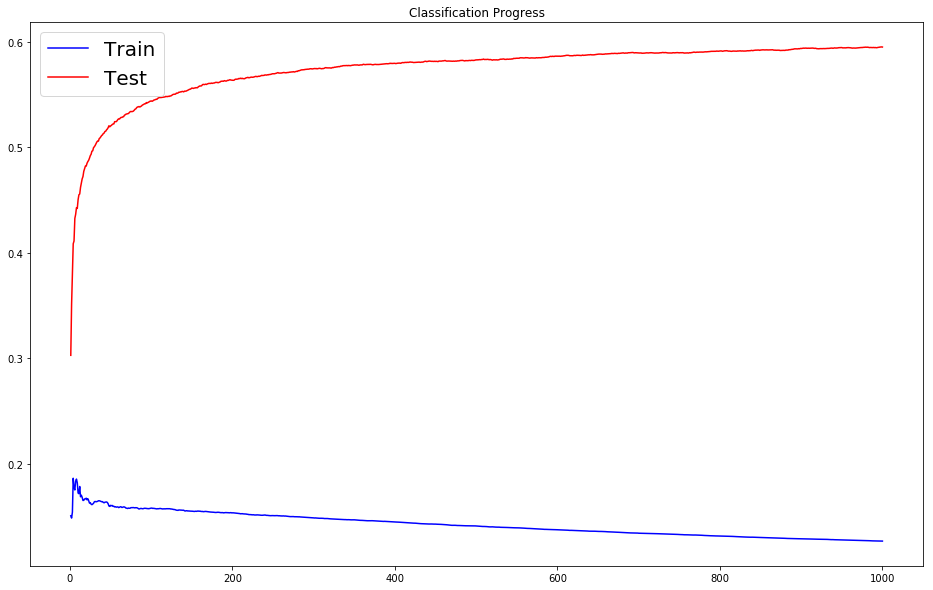

In [37]:
plt.plot(np.arange(1,gbm_model.n_estimators+1),perf_train,color='blue')
plt.plot(np.arange(1,gbm_model.n_estimators+1),perf_test,color='red')
plt.legend(['Train','Test'],fontsize=20)
plt.title('Classification Progress')
plt.show()

,importance
great,0.008524
good,0.006323
delicious,0.005647
best,0.005595
love,0.005228
awesome,0.004558
amazing,0.004552
ok,0.004167
excellent,0.004059
wa,0.003622


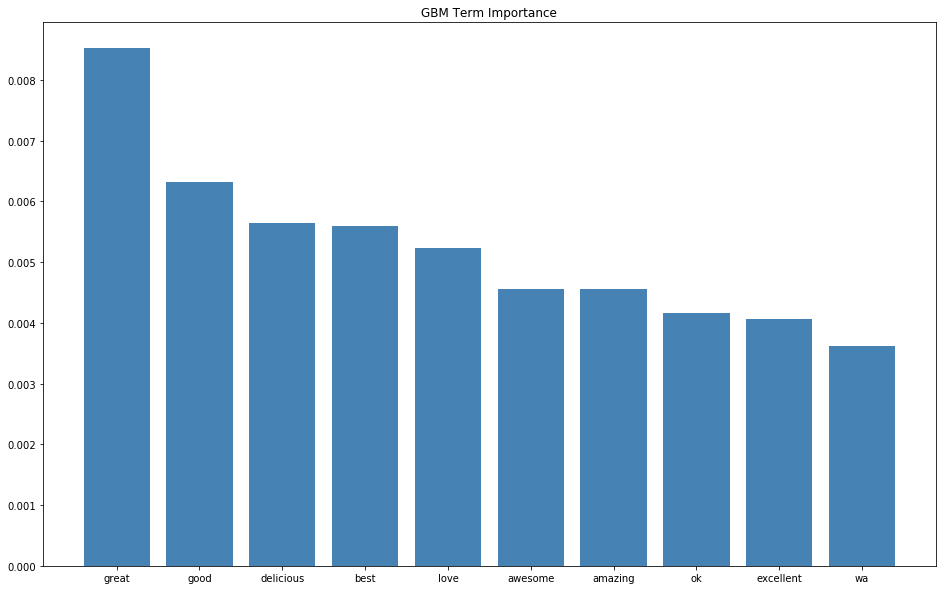

In [38]:
fi = pd.DataFrame({'importance':gbm_model.feature_importances_},index=feature_names).sort_values('importance',ascending=False)
display(fi.iloc[:10])

ticks = np.arange(10)
plt.bar(ticks,fi['importance'][:10],color='steelblue')
plt.xticks(ticks,fi.index)
plt.title('GBM Term Importance')
plt.show()

In [19]:
p = gbm_model.predict(tfidf_test.todense())
cm = metrics.confusion_matrix(test['score'],p)
display(cm)
for i in range(5):
    print(i+1,cm[i,i]/np.sum(cm[i,:]))
print()
print(metrics.accuracy_score(test['score'],p))

array([[7556, 1852,  290,  121,  181],
       [2300, 5168, 1897,  392,  243],
       [ 525, 1907, 5046, 2008,  514],
       [ 201,  344, 1788, 5028, 2639],
       [ 247,  146,  330, 2336, 6941]])

1 0.7556
2 0.5168
3 0.5046
4 0.5028
5 0.6941

0.59478
